In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import json
import re
import datetime
import ollama
from tqdm import tqdm
import openai

import plotly.express as px
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

# 
def draw_boxplot(metric_name, control_values, experimental_values):

    metrics = [metric_name,]

    data = []
    for metric in metrics:
        for group in ['Control', 'Experimental']:
            if group == 'Control':
                values = control_values
            elif group == 'Experimental':
                values = experimental_values
            for value in values:
                data.append([group, metric, value])

    # 创建 DataFrame
    df = pd.DataFrame(data, columns=['Group', 'Metric', 'Value'])

    # 绘制箱线图
    fig = px.box(df, x='Metric', y='Value', color='Group', 
                category_orders={'Metric': metrics},
                labels={'Value': 'Score', 'Metric': 'Clinical Task Metric'},
                #  title="Comparison of Clinical Task Performance between Control and Experimental Groups"
                )

    # 美化图形
    fig.update_layout(
        title_font=dict(size=20, family='Arial, sans-serif'),
        xaxis_title_font=dict(size=14, family='Arial, sans-serif'),
        yaxis_title_font=dict(size=14, family='Arial, sans-serif'),
        legend_title=dict(font=dict(size=14)),
        font=dict(family='Arial, sans-serif', size=12),
        boxmode='group',  # 分组箱线图
        plot_bgcolor='white',  # 背景白色
        showlegend=True,
        height=400,  # 缩小画幅高度
        width=500,   # 缩小画幅宽度
    )

    # 显示图形
    # fig.show()

    # 取两组数据
    control = df[df['Group'] == 'Control']['Value']
    experimental = df[df['Group'] == 'Experimental']['Value']

    # Mann-Whitney U 检验（非参数检验，适用于非正态分布）
    stat, p = mannwhitneyu(control, experimental, alternative='two-sided')
    print(f"Mann-Whitney U 检验: U={stat:.2f}, p-value={p:.4f}")

    # 可在图上添加显著性标记
    if p < 0.05:
        significance = '*'
    else:
        significance = 'ns'

    fig.add_annotation(
        x=0, y=max(df['Value']),
        text=f'p={p:.4f} {significance}',
        showarrow=False,
        font=dict(size=14, color='black'),
        yshift=20
    )
    fig.show()

    # 导出为PNG格式，分辨率设置为300DPI
    # fig.write_image("scatter_1.png", width=500, height=400, scale=3)


# 读取数据

dzz_records = pd.read_excel(r'D:\work\code\psychgpt\prospective\CRF\dzz.xlsx')
dzz_basic_df = pd.read_excel(r'D:\work\code\psychgpt\prospective\20250522\dzz基本信息.xlsx')
dzz_order_df = pd.read_excel(r'D:\work\code\psychgpt\prospective\20250522\dzz药品医嘱.xlsx')
dzz_scale_df = pd.read_excel(r'D:\work\code\psychgpt\prospective\20250522\dzz量表.xlsx')
dzz_sc_df = pd.read_excel(r'D:\work\code\psychgpt\prospective\20250522\dzz首程.xlsx')

syz_records = pd.read_excel(r'D:\work\code\psychgpt\prospective\CRF\syz.xlsx')
syz_basic_df = pd.read_excel(r'D:\work\code\psychgpt\prospective\20250522\syz基本信息.xlsx')
syz_order_df = pd.read_excel(r'D:\work\code\psychgpt\prospective\20250522\syz药品医嘱.xlsx')
syz_scale_df = pd.read_excel(r'D:\work\code\psychgpt\prospective\20250522\syz量表.xlsx')
syz_sc_df = pd.read_excel(r'D:\work\code\psychgpt\prospective\20250522\syz首程.xlsx')

medication_list_simple = [
    "氯硝西泮",
    "卡马西平",
    "苯妥英钠",
    "丙戊酸",
    "托吡酯",
    "氟西汀",
    "文拉法辛",
    "扎来普隆",
    "阿普唑仑",
    "佐匹克隆",
    "奋乃静",
    "安非他酮",
    "碳酸锂",
    "地西泮",
    "多巴丝肼",
    "奥沙西泮",
    "丙戊酸",
    "阿米替林",
    "氯硝西泮",
    "氟哌啶醇",
    "硝西泮",
    "氢溴酸西酞普兰",
    "文拉法辛",
    "盐酸丁螺环酮片",
    "氟伏沙明",
    "米安色林",
    "阿立哌唑",
    "度洛西汀",
    "坦度螺酮",
    "齐拉西酮",
    "度洛西汀",
    "帕利哌酮",
    "氨磺必利",
    "托莫西汀",
    "拉莫三嗪",
    "氢溴酸西酞普兰",
    "马来酸咪达唑仑",
    "劳拉西泮",
    "盐酸舍曲林",
    "奋乃静",
    "酒石酸唑吡坦",
    "氟哌啶醇",
    "氯丙嗪",
    "米氮平",
    "哌甲酯",
    "曲唑酮",
    "氯米帕明",
    "佐匹克隆",
    "喹硫平",
    "苯巴比妥",
    "地西泮",
    "哌罗匹隆",
    "安非他酮",
    "艾司唑仑",
    "阿立哌唑",
    "多塞平",
    "苯海索",
    "氯丙嗪",
    "甲钴胺",
    "舒必利",
    "谷维素",
    "氯氮平",
    "氟哌啶醇",
    "马普替林",
    "氟奋乃静",
    "氟哌噻吨",
    "碳酸锂",
    "丙戊酸",
    "五氟利多",
    "齐拉西酮",
    "米那普仑",
    "氯氮平",
    "可乐定透",
    "阿戈美拉汀",
    "喹硫平",
    "圣约翰草提取物",
    "布南色林",
    "伏硫西汀",
    "右佐匹克隆",
    "帕罗西汀",
    "帕利哌酮",
    "氟西汀",
    "鲁拉西酮",
    "托莫西汀",
    "普瑞巴林",
    "丙戊酸",
    "氟西汀",
    "利斯的明",
    "阿立哌唑",
    "帕利哌酮",
    "吡贝地尔",
    "氘丁苯那嗪",
    "普拉克索",
    "咪达唑仑",
    "拉莫三嗪",
    "氢溴酸西酞普兰",
    "恩他卡朋",
    "盐酸金刚烷胺",
    "甲磺酸雷沙吉兰",
    "盐酸司来吉兰",
    "水合氯醛",
    "甲钴胺",
    "氢溴酸加兰他敏",
    "卡左双多巴缓释",
    "苯甲酸利扎曲普坦",
    "恩他卡朋双多巴",
    "草酸艾司西酞普兰",
    "利培酮",
    "曲唑酮",
    "利培酮",
    "帕罗西汀",
    "美金刚",
    "奥氮平"
]

medication_list = [
    "氯硝西泮注射液",
    "卡马西平片",
    "苯妥英钠片",
    "丙戊酸钠片",
    "丙戊酸钠缓释片",
    "托吡酯片",
    "盐酸氟西汀分散片",
    "盐酸文拉法辛缓释胶囊",
    "盐酸文拉法辛胶囊",
    "扎来普隆胶囊",
    "阿普唑仑片",
    "佐匹克隆胶囊",
    "盐酸氟奋乃静片",
    "盐酸安非他酮片",
    "碳酸锂片",
    "地西泮片",
    "多巴丝肼片",
    "奥沙西泮片",
    "丙戊酸钠口服溶液",
    "盐酸阿米替林片",
    "氯硝西泮片",
    "氟哌啶醇注射液",
    "硝西泮片",
    "盐酸舍曲林分散片",
    "氢溴酸西酞普兰胶囊",
    "盐酸文拉法辛缓释片",
    "盐酸丁螺环酮片",
    "马来酸氟伏沙明片",
    "盐酸米安色林片",
    "枸橼酸坦度螺酮片",
    "阿立哌唑片",
    "盐酸度洛西汀肠溶片",
    "枸橼酸坦度螺酮胶囊",
    "盐酸齐拉西酮胶囊",
    "盐酸度洛西汀肠溶胶囊",
    "帕利哌酮缓释片",
    "氨磺必利片",
    "注射用利培酮微球",
    "盐酸托莫西汀胶囊",
    "拉莫三嗪片",
    "氢溴酸西酞普兰片",
    "马来酸咪达唑仑片",
    "劳拉西泮片",
    "盐酸舍曲林片",
    "利培酮口服溶液",
    "奋乃静片",
    "酒石酸唑吡坦片",
    "氟哌啶醇片",
    "盐酸氯丙嗪注射液",
    "米氮平片",
    "盐酸哌甲酯缓释片",
    "盐酸曲唑酮片",
    "盐酸氯米帕明片",
    "佐匹克隆片",
    "富马酸喹硫平片",
    "苯巴比妥片",
    "地西泮注射液",
    "盐酸哌罗匹隆片",
    "盐酸安非他酮缓释片",
    "艾司唑仑片",
    "阿立哌唑口崩片",
    "利培酮口崩片",
    "盐酸多塞平片",
    "盐酸苯海索片",
    "盐酸氯丙嗪片",
    "盐酸硫必利片",
    "甲钴胺片",
    "舒必利片",
    "谷维素片",
    "氯氮平片",
    "癸酸氟哌啶醇注射液",
    "盐酸马普替林片",
    "癸氟奋乃静注射液",
    "氟哌噻吨美利曲辛片",
    "碳酸锂缓释片",
    "丙戊酸镁缓释片",
    "五氟利多片",
    "棕榈酸帕利哌酮注射液",
    "注射用甲磺酸齐拉西酮",
    "盐酸米那普仑片",
    "氯氮平口腔崩解片",
    "可乐定透皮贴片",
    "阿戈美拉汀片",
    "富马酸喹硫平缓释片",
    "圣约翰草提取物",
    "布南色林片",
    "氢溴酸伏硫西汀片",
    "右佐匹克隆片",
    "盐酸帕罗西汀肠溶缓释片",
    "棕榈帕利哌酮酯注射液（3M）",
    "盐酸氟西汀片",
    "盐酸鲁拉西酮片",
    "盐酸托莫西汀口服溶液",
    "普瑞巴林胶囊",
    "丙戊酸钠缓释片(Ⅰ)",
    "盐酸氟西汀胶囊",
    "利斯的明透皮贴剂",
    "阿立哌唑口服溶液",
    "棕榈帕利哌酮酯注射液(3M)",
    "吡贝地尔缓释片",
    "氘丁苯那嗪片",
    "盐酸普拉克索片",
    "咪达唑仑注射液",
    "拉莫三嗪分散片",
    "氢溴酸西酞普兰口服溶液",
    "恩他卡朋片",
    "盐酸金刚烷胺片",
    "甲磺酸雷沙吉兰片",
    "盐酸司来吉兰片",
    "水合氯醛胶浆",
    "甲钴胺注射液",
    "氢溴酸加兰他敏片",
    "卡左双多巴缓释片",
    "苯甲酸利扎曲普坦片",
    "恩他卡朋双多巴片（Ⅱ）",
    "草酸艾司西酞普兰片",
    "利培酮口服液",
    "盐酸曲唑酮缓释片",
    "奥氮平片",
    "利培酮片",
    "盐酸帕罗西汀片",
    "盐酸美金刚片",
    "奥氮平口崩片"
]

In [81]:
# 1 问诊时间
print("="*25+"问诊时间"+"="*25)
dzz_records = pd.read_excel(r'D:\work\code\psychgpt\prospective\CRF\dzz.xlsx')
syz_records = pd.read_excel(r'D:\work\code\psychgpt\prospective\CRF\syz.xlsx')

interview_time_dzz = dzz_records['Interview_time'].tolist() # minute
print(interview_time_dzz)
print(len(interview_time_dzz))
print(f"对照组问诊时间：{np.mean(interview_time_dzz)} +- {np.std(interview_time_dzz)}")

interview_time_syz = syz_records['Interview_time'].tolist() # minute
print(interview_time_syz)
print(len(interview_time_syz))
print(f"实验组问诊时间：{np.mean(interview_time_syz)} +- {np.std(interview_time_syz)}")

draw_boxplot("问诊时间", interview_time_dzz, interview_time_syz)

print("="*50)

=========================问诊时间=========================
[10.0, 120.0, 20.0, 20.0, 30.0, 5.0, 20.0, 20.0, 60.0, 30.0, 30.0, 10.0, 10.0, 30.0, 30.0, 30.0, 30.0, 20.0, 30.0, 40.0, 40.0, 60.0, 30.0, 10.0, 60.0, 30.0, 40.0, 40.0, 40.0, 50.0, 20.0, 20.0, 30.0, 60.0, 30.0, 30.0, 30.0, 10.0, 40.0, 120.0, 30.0, 60.0, 40.0, 30.0, 90.0, 45.0, 40.0, 40.0, 120.0, 45.0, 40.0, 15.0, 60.0, 120.0, 120.0, 60.0, 40.0, 60.0, 60.0, 30.0, 30.0, 30.0, 30.0, 40.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 20.0, 45.0, 90.0, 60.0, 30.0, 90.0, 30.0, 60.0, 80.0, 60.0, 60.0, 60.0, 50.0, 60.0, 60.0, 40.0, 60.0, 60.0, 20.0, 60.0, 60.0, 40.0, 70.0, 70.0, 60.02, 60.0, 25.0, 45.0, 40.0]
101
对照组问诊时间：44.20811881188119 +- 25.051879979764735
[35.0, 0.0, 0.0, 0.0, 10.0, 50.0, 15.0, 19.96, 15.0, 60.0, 43.0, 49.0, 40.0, 60.0, 20.0, 30.0, 20.0, 50.0, 50.0, 50.0, 45.0, 40.0, 30.0, 75.0, 45.0, 60.0, 45.0, 30.0, 30.0, 15.0, 40.0, 40.0, 30.0, 40.0, 30.0, 60.0, 90.0, 90.0, 20.0, 40.0, 20.0, 30.0, 30.0, 30.0, 30.0, 100.0, 30.0,

In [83]:
# 8 病历撰写时间
print("="*25+"病历撰写时间"+"="*25)
dzz_records = pd.read_excel(r'D:\work\code\psychgpt\prospective\CRF\dzz.xlsx')
syz_records = pd.read_excel(r'D:\work\code\psychgpt\prospective\CRF\syz.xlsx')

write_time_dzz = dzz_records['FirstCourse_time'].tolist() # minute
print(write_time_dzz)
print(len(write_time_dzz))
print(f"对照组病历撰写时间：{np.mean(write_time_dzz)} +- {np.std(write_time_dzz)}")

write_time_syz = syz_records['FirstCourse_time'].tolist() # minute
print(write_time_syz)
print(len(write_time_syz))
print(f"实验组病历撰写时间：{np.mean(write_time_syz)} +- {np.std(write_time_syz)}")

draw_boxplot("病历撰写时间", write_time_dzz, write_time_syz)
print("="*50)

=========================病历撰写时间=========================
[10.0, 10.0, 20.0, 10.0, 15.0, 10.0, 10.0, 15.0, 10.0, 10.0, 20.0, 10.0, 18.0, 10.0, 10.0, 12.0, 13.0, 15.0, 15.0, 15.0, 15.0, 25.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 25.0, 15.0, 15.0, 15.0, 15.0, 15.0, 25.0, 15.0, 15.0, 16.0, 19.0, 20.0, 20.0, 20.0, 25.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 25.0, 25.0, 25.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.04, 30.04, 40.0, 40.0, 42.0, 45.0, 8.0]
101
对照组病历撰写时间：21.21861386138614 +- 7.700209721935375
[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.02, 13.0, 14.97, 15.0, 15.0, 10.0, 15.0, 5.0, 15.0, 15.0, 15.0, 15.0, 10.0, 15.0, 15.0, 10.0,

In [ ]:
# 2 问诊全面性 （专家打分）

print("="*25+"问诊全面性"+"="*25)

interview_content_dzz = dzz_basic_df['现病史'].tolist()
interview_score_dzz = []
for content in tqdm(interview_content_dzz):
    query = f"""请根据以下评分标准，对低年资医生通过向患者问诊后撰写的现病史内容的全面性进行评分。只输出最终评分，不要输出任何其他内容。评分标准如下：
    问诊内容应包括：
    1. 起病情况：年龄、诱因（社会心理因素/躯体因素/无诱因）、发病形式（急性/亚急性/慢性）。关键点：是否明确诱因性质（如具体生活事件）、发病时间节点（如精确到周/月）。
    2. 病程特点：总病程时长、波动性（发作性/持续性）、加重或缓解因素（如季节、应激事件）。关键点：是否描述症状演变趋势（如进行性加重或周期性缓解）。
    3. 临床表现：早期症状（首发症状、前驱症状）、核心症状（如幻觉、妄想、情感症状）。关键点：是否区分症状的严重程度（如对功能的影响）及症状群关联性。
    4. 鉴别诊断信息：阳性症状（支持主诊断的特征）、阴性症状（排除其他疾病的依据，如器质性疾病证据、物质滥用史）。关键点：是否主动询问躯体疾病史、家族史、物质使用史。
    5. 既往治疗史：既往诊断（具体诊断名称）、用药史（药物名称、剂量、疗程、疗效、副作用）。关键点：是否记录治疗依从性及患者对治疗的主观反馈。
    6. 社会功能评估：病后职业/学业、人际交往、日常生活能力变化（需量化，如缺勤天数、社交回避频率）。关键点：是否使用标准化工具（如GAF量表）或具体行为描述。
    7. 伴随症状：躯体症状（睡眠、食欲、躯体疼痛）、认知功能（注意力、记忆力）、自杀/自伤风险。关键点：是否评估生物学症状（如早醒）及风险行为细节。
    
    评分标准（5分制）：
    5分：7项均完整且包含细节（如诱因具体化、病程时间轴、症状量化描述、鉴别依据明确）。
    4分：7项完整，但≤2项缺乏细节（如仅记录“有诱因”未说明内容）。
    3分：1项关键信息缺失，或≥3项信息笼统。
    2分：2项关键信息缺失。
    1分：≥3项关键信息缺失，或遗漏核心模块（如未问诊自杀风险）。
    
    评分说明
    “关键信息缺失”定义：任一核心模块（1-7项）完全未涉及。
    “信息详细”标准：需包含具体描述而非笼统回答（如“因失业发病”优于“有诱因”）。
    鉴别诊断加分项：主动询问非精神科问题（如甲状腺功能、脑损伤史）额外加权。
    
    问诊后撰写的现病史：
    {content}
    
    """
    response = ollama.chat(
        model="qwen2.5:3b",
        messages=[
            {"role": "user", "content": query},
        ],
    )
    print(response['message']['content'])
    
    interview_score_dzz.append(response['message']['content'])
print(interview_score_dzz)

print("="*50)

In [ ]:
# 计算指标





# 3 诊断准确率

# print("="*25+"诊断准确率"+"="*25)

# initial_diagnosis_all = []
# final_diagnosis_all = []
# diagnosis_accuracy_dzz = []

# 根据首程计算
# for ipid in tqdm(dzz_basic_df['IPID'].tolist()):
#     final_diagnosis = dzz_basic_df[dzz_basic_df['IPID'] == ipid]['出院主要诊断'].iloc[0]
#     final_diagnosis_all.append(final_diagnosis)
    
#     initial_diagnosis = dzz_sc_df[dzz_sc_df['SYXH'] == ipid]['YZTL'].iloc[0]
#     initial_diagnosis = re.search(r"入院印象：(.*?)鉴别诊断", initial_diagnosis, re.DOTALL).group(1).strip()
#     initial_diagnosis_all.append(initial_diagnosis)
    
#     print(f"{initial_diagnosis} || {final_diagnosis}")

# 根据CRF记录计算
# for patient in tqdm(dzz_records.iterrows()):
#     ipid = patient[1]['IPID']
#     initial_diagnosis = patient[1]['Diagnosis']
#     initial_diagnosis_all.append(initial_diagnosis)
    
#     if len(dzz_basic_df[dzz_basic_df['IPID'] == ipid]['出院主要诊断']) != 0:
#         final_diagnosis = dzz_basic_df[dzz_basic_df['IPID'] == ipid]['出院主要诊断'].iloc[0]
#     elif len(dzz_basic_df[dzz_basic_df['ADMINISSION_NO'] == ipid]['出院主要诊断']) != 0:
#         final_diagnosis = dzz_basic_df[dzz_basic_df['ADMINISSION_NO'] == ipid]['出院主要诊断'].iloc[0]
#     else:
#         continue
    
#     final_diagnosis_all.append(final_diagnosis)
#     print(f"{ipid} || {initial_diagnosis} || {final_diagnosis}")
        
# print(initial_diagnosis_all)
# print(len(initial_diagnosis_all))
# print(final_diagnosis_all)
# print(len(final_diagnosis_all))

# print("="*50)

# 4 诊断全面性 （结合病程管理来看）

# print("="*25+"诊断全面性"+"="*25)
# initial_diagnosis_other_all = []
# final_diagnosis_other_all = []
# diagnosis_comprehensive_dzz = []

# for ipid in tqdm(dzz_basic_df['IPID'].tolist()):
#     final_diagnosis = dzz_basic_df[dzz_basic_df['IPID'] == ipid]['出院其他诊断'].iloc[0]
#     final_diagnosis_other_all.append(final_diagnosis)
    
#     initial_diagnosis = dzz_sc_df[dzz_sc_df['SYXH'] == ipid]['YZTL'].iloc[0]
#     initial_diagnosis = re.search(r"入院印象：(.*?)鉴别诊断", initial_diagnosis, re.DOTALL).group(1).strip()
#     initial_diagnosis_other_all.append(initial_diagnosis)
    
#     print(f"{ipid} || {initial_diagnosis} || {final_diagnosis}")


# print("="*50)

# 5 鉴别准确性 （专家打分）

# print("="*25+"鉴别准确性"+"="*25)

# differential_content_dzz = dzz_sc_df['YZTL'].tolist()
# differential_score_dzz = []
# for content in tqdm(differential_content_dzz):
#     content = re.search(r"鉴别诊断：(.*?)诊疗计划：", content, re.DOTALL).group(1).strip()
#     query = f"""请从精神科临床专家的角度，对下面精神科医生对某位患者给出的鉴别诊断分析进行评分。只输出最终评分，不要输出任何其他内容。评分标准如下：
#     1. 是否排除至少3种以上需鉴别的疾病。
#     2. 是否根据患者具体情况，说明每项鉴别疾病的排除依据。
#     3. 对于尚无法排除的疾病，是否说明后续鉴别的方法。
    
#     评分标准（5分制）：
#     5分：鉴别诊断全面，至少排除3种以上疾病，并说明每项疾病的排除依据。
#     4分：鉴别诊断较全面，排除3种以上疾病，但缺乏具体的排除依据。
#     3分：鉴别诊断一般，仅排除2种疾病，或缺乏具体的排除依据。
#     2分：鉴别诊断较差，仅排除1种疾病，或缺乏具体的排除依据。
#     1分：鉴别诊断差，未排除任何疾病，或缺乏具体的排除依据。
    
#     鉴别诊断分析：
#     {content}
    
#     """
#     response = ollama.chat(
#         model="qwen2.5:3b",
#         messages=[
#             {"role": "user", "content": query},
#         ],
#     )
#     print(response['message']['content'])
    
#     differential_score_dzz.append(response['message']['content'])

# print(differential_score_dzz)

# print("="*50)

# 6 鉴别全面性

# print("="*25+"鉴别全面性"+"="*25)

# differential_content_dzz = dzz_sc_df['YZTL'].tolist()
# differential_comprehensive_dzz = []

# for content in tqdm(differential_content_dzz):
#     content = re.search(r"鉴别诊断：(.*?)诊疗计划：", content, re.DOTALL).group(1).strip()
    
#     print(content)
#     num_differential = len(re.findall(r'\d+[.、]', content, re.DOTALL))
#     print(num_differential)
    
#     differential_comprehensive_dzz.append(num_differential)

# print(differential_comprehensive_dzz)

# print("="*50)

# 7 用药准确性 （区分有无转相，分组计算）

# print("="*25+"问诊时间"+"="*25)

# medication_initial_dzz_all = []
# medication_final_dzz_all = []
# correct_medication_all = []

# # 根据CRF记录计算
# for patient in tqdm(dzz_records.iterrows()):
#     ipid0 = patient[1]['IPID']
#     medication_initial_dzz = re.split(',|、|，| ', patient[1]['Treatment'])
#     medication_initial_dzz_all.append(medication_initial_dzz)
#     try:
#         ipid1 = dzz_basic_df[dzz_basic_df['ADMINISSION_NO'] == ipid0]['IPID'].iloc[0]
#     except:
#         ipid1 = ipid0
    
#     if len(dzz_order_df[dzz_order_df['IPID'] == ipid0]['药品名称']) != 0:
#         medication_final_dzz = list(set(dzz_order_df[dzz_order_df['IPID'] == ipid0]['药品名称'].tolist()))
#     elif len(dzz_order_df[dzz_order_df['IPID'] == ipid1]['药品名称']) != 0:
#         medication_final_dzz = list(set(dzz_order_df[dzz_order_df['IPID'] == ipid1]['药品名称'].tolist()))
#     else:
#         continue
    
#     medication_final_psych_dzz = []
#     for medication in medication_final_dzz:
#         if medication in medication_list:
#             medication_final_psych_dzz.append(medication)
            
    
#     medication_final_dzz_all.append(medication_final_psych_dzz)
    
    
#     correct_medication = []
#     for medication in medication_initial_dzz:
#         if any(medication in s for s in medication_list_simple):
#             correct_medication.append(medication)
    
#     correct_medication_all.append(len(correct_medication)/len(medication_final_psych_dzz))
    
#     print(f"{ipid0} || {medication_initial_dzz} || {medication_final_psych_dzz} || {len(correct_medication)/len(medication_final_psych_dzz)}")
    

# print("="*50)




# 9 患者量表评估 （部分患者住院时长不够4周）

# # 汉密尔顿抑郁量表
# hamd_w1_dzz = []
# hamd_w2_dzz = []
# hamd_w3_dzz = []
# hamd_w4_dzz = []

# hamds_dzz = dzz_scale_df[dzz_scale_df['量表名'] == '汉密尔顿抑郁量表']
# hamds_dzz = hamds_dzz.dropna(subset=['记录时间', '总分', '题目', '分值'])

# for ipid in hamds_dzz['IPID'].unique():
#     patients = hamds_dzz[hamds_dzz['IPID'] == ipid]
#     records = patients.groupby('记录时间')
#     num = 0
#     for record_time, group in records:
#         if num == 0:
#             hamd_w1_dzz.append(group.iloc[0]['总分'])
#             num += 1
#         elif num == 1:
#             hamd_w2_dzz.append(group.iloc[0]['总分'])
#             num += 1
#         elif num == 2:
#             hamd_w3_dzz.append(group.iloc[0]['总分'])
#             num += 1
#         elif num == 3:
#             hamd_w4_dzz.append(group.iloc[0]['总分'])
#             num += 1
        
# print(f"{len(hamd_w1_dzz)}, {hamd_w1_dzz}")
# print(f"{len(hamd_w2_dzz)}, {hamd_w2_dzz}")
# print(f"{len(hamd_w3_dzz)}, {hamd_w3_dzz}")
# print(f"{len(hamd_w4_dzz)}, {hamd_w4_dzz}")

# # CGI 疾病改善量表


# # 自评量表


43, [12.0, 23.0, 31.0, 18.0, 30.0, 6.0, 0.0, 27.0, 19.0, 25.0, 0.0, 14.0, 14.0, 6.0, 21.0, 3.0, 11.0, 18.0, 6.0, 0.0, 28.0, 0.0, 14.0, 2.0, 2.0, 27.0, 4.0, 9.0, 31.0, 30.0, 11.0, 25.0, 7.0, 23.0, 14.0, 34.0, 23.0, 24.0, 4.0, 16.0, 15.0, 0.0, 3.0]
36, [14.0, 17.0, 18.0, 14.0, 11.0, 0.0, 15.0, 6.0, 6.0, 0.0, 0.0, 7.0, 3.0, 15.0, 7.0, 10.0, 0.0, 19.0, 0.0, 16.0, 4.0, 1.0, 12.0, 0.0, 0.0, 17.0, 19.0, 8.0, 5.0, 7.0, 15.0, 27.0, 21.0, 9.0, 0.0, 3.0]
28, [9.0, 15.0, 6.0, 8.0, 0.0, 11.0, 4.0, 2.0, 0.0, 0.0, 2.0, 7.0, 6.0, 6.0, 0.0, 10.0, 0.0, 15.0, 3.0, 0.0, 0.0, 4.0, 11.0, 11.0, 10.0, 12.0, 12.0, 5.0]
16, [6.0, 10.0, 2.0, 3.0, 7.0, 4.0, 0.0, 4.0, 13.0, 0.0, 7.0, 15.0, 5.0, 10.0, 7.0, 7.0]


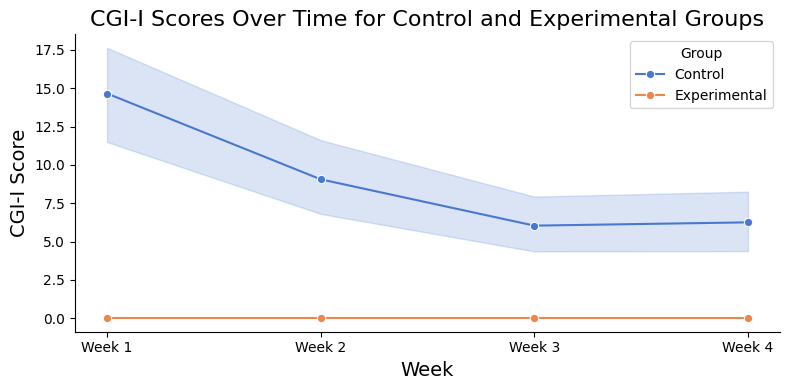

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 设置随机种子以保证可重复性
np.random.seed(42)

# 模拟数据
weeks = np.array([1, 2, 3, 4])  # 4周的时间
groups = np.array(['Control', 'Experimental'])  # 两组
num_patients = 100  # 每组100个患者

# 生成模拟评分数据
data = []
for group in groups:
    for week in weeks:
        # 生成每周的CGI-I评分数据（模拟评分）
        if group == 'Control':
            if week == 1:
                scores = np.array(hamd_w1_dzz)
            elif week == 2:
                scores = np.array(hamd_w2_dzz)
            elif week == 3:
                scores = np.array(hamd_w3_dzz)
            elif week == 4:
                scores = np.array(hamd_w4_dzz)
        else:
            if week == 1:
                scores = np.array([0])
            elif week == 2:
                scores = np.array([0])
            elif week == 3:
                scores = np.array([0])
            elif week == 4:
                scores = np.array([0])
        for score in scores:
            data.append([group, week, score])

# 创建DataFrame
df = pd.DataFrame(data, columns=['Group', 'Week', 'CGI_Score'])

# 显示前几行数据
df.head()


plt.figure(figsize=(8, 4))
sns.lineplot(x='Week', y='CGI_Score', hue='Group', data=df, marker='o', palette='muted')
plt.title('CGI-I Scores Over Time for Control and Experimental Groups', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('CGI-I Score', fontsize=14)
plt.xticks([1, 2, 3, 4], ['Week 1', 'Week 2', 'Week 3', 'Week 4'])
plt.legend(title='Group')
plt.tight_layout()
sns.despine()
plt.grid(False)
plt.show()




# plt.figure(figsize=(10, 6))
# sns.lineplot(x='Week', y='CGI_Score', hue='Group', data=df, marker='o', ci="sd", palette='muted')
# plt.title('CGI-I Scores Over Time for Control and Experimental Groups', fontsize=16)
# plt.xlabel('Week', fontsize=14)
# plt.ylabel('CGI-I Score', fontsize=14)
# plt.xticks([1, 2, 3, 4], ['Week 1', 'Week 2', 'Week 3', 'Week 4'])
# plt.legend(title='Group')
# plt.tight_layout()
# plt.show()



In [23]:
import re

print(interview_score_dzz)
interview_score_int = []
for score in interview_score_dzz:
    match = re.search(r'\d+', str(score))
    if match:
        interview_score_int.append(int(match.group()))
print(interview_score_int)
print(len(interview_score_int))
print(np.mean(interview_score_int))
print(np.std(interview_score_int))

['2', '2分', '根据您提供的信息，该用户似乎经历了一系列精神健康问题，包括双相情感障碍和可能的应激反应或创伤后压力症状。以下是一些建议，但请注意，在实际操作中需要专业医护人员的详细评估与指导：\n\n1. **医疗治疗**：持续遵循医生开具的药物处方，并定期复诊以监测病情变化及调整用药方案。\n\n2. **心理支持**：\n   - 开展认知行为疗法等心理干预措施。\n   - 参加患者教育和支持小组，与其他经历类似情况的人交流心得。\n   - 如果需要的话，可以寻求精神科医师的帮助，进行个体或团体心理咨询治疗。\n\n3. **环境调整**：\n   - 保持居住环境整洁有序，减少潜在刺激因素。\n   - 增强家庭成员之间的沟通与理解，尽量避免冲突。\n\n4. **安全措施**：确保家中安全无隐患，必要时安装监控设备。当情绪失控危险时，请采取适当措施保护自己和他人的安全（例如将尖锐物品放在远离儿童的地方）。\n\n5. **社会支持网络**：\n   - 加入社区组织或兴趣小组，与志同道合的人建立联系。\n   - 保持乐观积极的心态，同时也要认识到寻求专业帮助的重要性。\n\n6. **健康生活方式**：适量运动、均衡饮食、充足睡眠对于改善整体身心健康非常重要。\n\n7. **紧急情况处理计划**：\n   - 制定家庭成员都知晓的紧急应对措施和联系方式。\n   - 确保始终随身携带身份证件以及必要的医疗文件复印件。\n\n请注意，由于涉及到了一些复杂的人身安全问题，在实际操作中需要谨慎考虑并寻求专业机构的指导。如果发现该用户的行为有威胁到自身或他人生命安全的风险，请立即联系警方和医疗机构求助。', '根据您提供的病史描述，这位患者的情况涉及反复发作的双相情感障碍。这种疾病的特点是情绪状态在躁狂期和抑郁期之间波动。对于该患者的管理需要多方面的考虑，包括药物治疗、心理支持和社会干预。\n\n以下是一些可能有助于管理和改善病情的建议：\n\n1. **持续监测与定期评估**：由于患者有频繁复发的情况，应该建立一个详细的跟踪机制，并定期进行专业评估以调整治疗方案。\n   \n2. **合适的抗精神病药和锂盐使用**：根据之前的治疗经验，患者的药物组合（喹硫平、碳酸锂等）可能需要进一步调整。可能需要增加剂量或更换为其他有效的双相障碍维持药物。\n

In [7]:
records_ipids = dzz_records['IPID'].tolist()
find_ipids = dzz_basic_df['IPID'].tolist()
find_mrids = dzz_basic_df['ADMINISSION_NO'].tolist()
print(len(records_ipids))
# print(find_mrids)
# print(find_ipids)
not_found_ipids = []
for ipid in records_ipids:
    if ipid not in find_ipids and ipid not in find_mrids:
        # print(ipid)
        not_found_ipids.append(ipid)

print(not_found_ipids)
print(len(not_found_ipids))


101
[159702, 159803, 159798, 44, 159839, 159840, 157908, 44968, 157535, 41, 142136, 34093, 89576, 160088, 160163, 160171, 116120, 133287, 82380, 60292, 18, 118998, 160311, 120890, 160354, 160382, 159057, 9, 159751, 160426, 160438, 148923, 86204, 160478, 160523, 160540, 160474, 160341, 160537, 31, 62, 160669, 130879, 160708, 155999, 135662, 160764]
47


In [ ]:
# post reader study
# 比较在病例分析方面，PsychGPT与不同年资精神科专业医生的表现

from docx import Document
import re

def read_docx(filename):
    doc = Document(filename)
    text = []
    for paragraph in doc.paragraphs:
        text.append(paragraph.text)
    return '\n'.join(text)


# PsychGPT
diagnosis_data = []
with open(r'D:\work\code\psychgpt\prospective\post_readerstudy\task2_psychgpt.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        newline = eval(line)
        diagnosis_data.append(newline)

differential_data = []
with open(r'D:\work\code\psychgpt\prospective\post_readerstudy\task3_psychgpt.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        newline = eval(line)
        differential_data.append(newline)

medication_data = []
with open(r'D:\work\code\psychgpt\prospective\post_readerstudy\task4_psychgpt.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        newline = eval(line)
        medication_data.append(newline)

data = []
for i in range(len(diagnosis_data)):
    patient_info = diagnosis_data[i]['conversations'][0]['value'].split('请根据你的知识给出专业详细的回答。\n')[1]
    diagnosis = diagnosis_data[i]['chosen']['value']
    differential = differential_data[i]['chosen']['value']
    medication = medication_data[i]['chosen']['value']
    data.append({
        'patient_info': patient_info,
        'psychgpt_diagnosis': diagnosis,
        'psychgpt_differential': differential,
        'psychgpt_medication': medication
    })


# 医生
path = r"D:\work\code\psychgpt_benchmark\reader-study\results\全部回答.docx"
content = read_docx(path)

# print(content)
cases = re.split(r'病例\d+', content)[1:]
for i, case in enumerate(cases):
    
    junior_answers = re.search(r'第一组：(.*?)第二组：', case, re.DOTALL).group(1).strip()
    intermediate_answers = re.search(r'第三组：(.*?)第四组：', case, re.DOTALL).group(1).strip()
    senior_answers = re.search(r'第五组：(.*?)第六组：', case, re.DOTALL).group(1).strip()
    
    if junior_answers == '============================================================':
        junior_answers = '问题1：未提供\n问题2：未提供\n问题3：未提供'
    if intermediate_answers == '============================================================':
        intermediate_answers = '问题1：未提供\n问题2：未提供\n问题3：未提供'
    if senior_answers == '============================================================':
        senior_answers = '问题1：未提供\n问题2：未提供\n问题3：未提供'
    
    data[i]['junior_diagnosis'] = re.search(r'问题1(.*?)问题2', junior_answers, re.DOTALL).group(1).strip()
    data[i]['junior_differential'] = re.search(r'问题2(.*?)问题3', junior_answers, re.DOTALL).group(1).strip()
    try:
        data[i]['junior_medication'] = re.search(r'问题3(.*?)问题1', junior_answers, re.DOTALL).group(1).strip()
    except:
        data[i]['junior_medication'] = re.search(r'问题3(.*?)', junior_answers, re.DOTALL).group(1).strip()

    data[i]['intermediate_diagnosis'] = re.search(r'问题1(.*?)问题2', intermediate_answers, re.DOTALL).group(1).strip()
    data[i]['intermediate_differential'] = re.search(r'问题2(.*?)问题3', intermediate_answers, re.DOTALL).group(1).strip()
    try:
        data[i]['intermediate_medication'] = re.search(r'问题3(.*?)问题1', intermediate_answers, re.DOTALL).group(1).strip()
    except:
        data[i]['intermediate_medication'] = re.search(r'问题3(.*?)', intermediate_answers, re.DOTALL).group(1).strip()
        
    data[i]['senior_diagnosis'] = re.search(r'问题1(.*?)问题2', senior_answers, re.DOTALL).group(1).strip()
    data[i]['senior_differential'] = re.search(r'问题2(.*?)问题3', senior_answers, re.DOTALL).group(1).strip()
    try:
        data[i]['senior_medication'] = re.search(r'问题3(.*?)问题1', senior_answers, re.DOTALL).group(1).strip()
    except:
        data[i]['senior_medication'] = re.search(r'问题3(.*?)', senior_answers, re.DOTALL).group(1).strip()
    

print(len(data))
print(data[0])

with open(r'D:\work\code\psychgpt\prospective\post_readerstudy\psychgpt_psychiatrists.jsonl', 'w', encoding='utf-8') as f:
    for line in data:
        f.write(json.dumps(line, ensure_ascii=False) + '\n')


100
{'patient_info': '患者女性，53岁。\n现病史：2013年左右患者开始信佛，家中供奉佛龛，因帮女儿带孩子，患者尚未投入过多精力，能正常照顾孩子，完成家务。近一年，女儿辞职在家带孩子，患者自己时间较前增多，逐步沉迷学佛，家属觉与患者聊天“不在同一频道”，不与家人聊家长里短的事情，整日做学佛相关的事情，家属诉一天中有90%左右的时间都在干与佛教相关的事。以前可以和女儿出去运动，美容，近一年也少参加，总在家打坐、念经。2022年1月9号下午，家属回家后发现患者在床上躺着，语乱，说有人要杀自己，自己要去杀人，说别人是谁谁转世，家人、亲戚朋友是狐狸精，耽误自己转世，要把他弄死。手乱比划，咬住家人不松口。家人报警，在120协助下来我院急诊。急诊诊断为“缄默状态、焦虑状态”，给予氟哌啶醇5mg肌注治疗，状态有改善，能交流，对之前发生的事情能够回忆。1月10日家人带其到某医院就诊，住院治疗10天，诊断“急性而短暂的精神障碍”，予以利培酮2mg/晚，劳拉西泮0.5mg/晚治疗，自觉好转后出院。出院服药2天自行停药，停药后情绪低落、周身不适、紧张胸闷、呼吸困难，停药1天恢复用药，症状有所改善，合并中药调理身体，但仍有以上问题。家人担心患者身体有其他问题，1月25日至1月30日在潞河医院住院治疗，做了详细身体检查，未见明显异常。加用氢溴酸西酞普兰10mg/晚，利培酮2mg/晚，劳拉西泮0.5mg/晚治疗，今日再次来我院就诊门诊以“抑郁状态”第1次收入院。本次为非自愿入院。入院前2周，患者饮食可，夜眠可，小便正常，有便秘，体重无明显变化。无发热、咳嗽、腹泻等表现。患者为非自愿住院，家属已签署非自愿住院相关协议书。\n既往史：2019年因月经不调行刮宫术\n家族史：阳性，患者姨疑似精神异常，未予诊治\n查体，精神检查及辅助检查：查体未见明显异常。辅助检查：2022-02-10，超声：目前心脏未见明显异常；2022-02-10，超声：肝内钙化灶；2022-02-10，心电图：窦性心律，大致正常心电图。补充诊断：肝内钙化点。\n精神检查：患者意识清晰，定向力完整，接触可，问答合作，患者报告对家属提供病史内容能够承认，自诉在来我院急诊前，自己多独自在家，会觉有人支配自己，会说一些胡话，如狐狸精、观音转世之类的话，在我院急诊接受治疗后好转，之后未再出现言行紊乱问题；患者诉近

In [58]:
# post reader study
path = r'D:\work\code\psychgpt\prospective\post_readerstudy\reader_scores.jsonl'

# // A给出的病例分析：{psychgpt_ans}
# // B给出的病例分析：{junior_ans}
# // C给出的病例分析：{intermediate_ans}
# // D给出的病例分析：{senior_ans}

# // A给出的病例分析：{junior_ans}
# // B给出的病例分析：{intermediate_ans}
# // C给出的病例分析：{senior_ans}
# // D给出的病例分析：{psychgpt_ans}

# // A给出的病例分析：{intermediate_ans}
# // B给出的病例分析：{psychgpt_ans}
# // C给出的病例分析：{junior_ans}
# // D给出的病例分析：{senior_ans}

data = []
with open(path, 'r', encoding='utf-8') as f:
    for line in f:
        newline = eval(line)
        data.append(newline)
print(len(data))

best = []

for i in range(len(data)):
    if i >= 0 and i < 100:
        if data[i]['偏好排序'][0] == 'A':
            best.append('PsychGPT')
        elif data[i]['偏好排序'][0] == 'B':
            best.append('Junior')
        elif data[i]['偏好排序'][0] == 'C':
            best.append('Intermediate')
        elif data[i]['偏好排序'][0] == 'D':
            best.append('Senior')
    elif i >= 100 and i < 200:
        if data[i]['偏好排序'][0] == 'A':
            best.append('Junior')
        elif data[i]['偏好排序'][0] == 'B':
            best.append('Intermediate')
        elif data[i]['偏好排序'][0] == 'C':
            best.append('Senior')
        elif data[i]['偏好排序'][0] == 'D':
            best.append('PsychGPT')
    elif i >= 200 and i < 300:
        if data[i]['偏好排序'][0] == 'A':
            best.append('Intermediate')
        elif data[i]['偏好排序'][0] == 'B':
            best.append('PsychGPT')
        elif data[i]['偏好排序'][0] == 'C':
            best.append('Junior')
        elif data[i]['偏好排序'][0] == 'D':
            best.append('Senior')

print(best)
print(best.count('PsychGPT'))
print(best.count('Junior'))
print(best.count('Intermediate'))
print(best.count('Senior'))

300
['PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'Senior', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'Senior', 'Senior', 'Junior', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'Senior', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'Senior', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'Senior', 'PsychGPT', 'PsychGPT', 'Junior', 'Senior', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'Senior', 'Junior', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'Senior', 'PsychGPT', 'Intermediate', 'Intermediate', 'PsychGPT', 'PsychGPT', 'Junior', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'Senior', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'Senior', 'PsychGPT', 'Senior', 'Senior', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'Senior', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'PsychGPT', 'Senior', 'PsychGPT', 'Psyc

c:\Users\15113\anaconda3\envs\anding\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\15113\anaconda3\envs\anding\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\15113\anaconda3\envs\anding\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\15113\anaconda3\envs\anding\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\15113\anaconda3\envs\anding\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49})

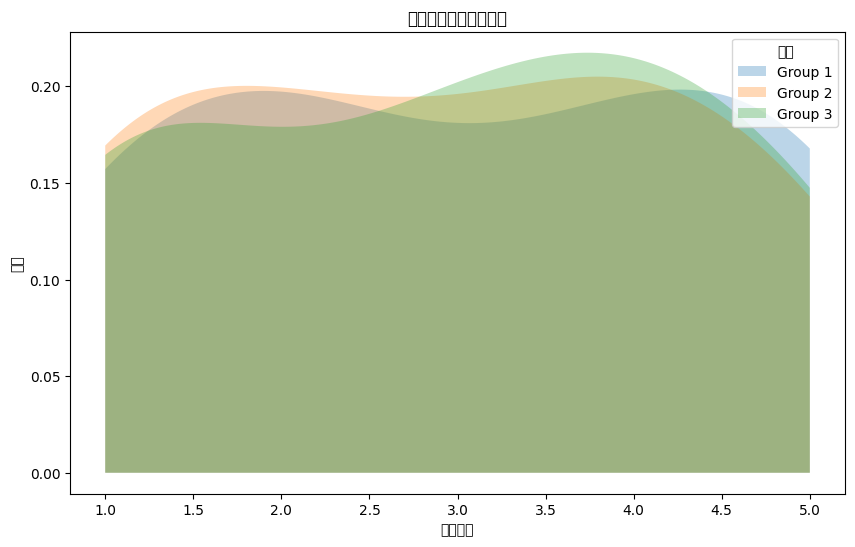

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 设置随机种子以保证结果可复现
np.random.seed(42)

# 生成仿真数据
categories = ['Very poor', 'Poor', 'Acceptable', 'Good', 'Very good']
data = {
    'Category': np.repeat(categories, 100),
    'Score': np.random.choice([1, 2, 3, 4, 5], size=500),
    'Group': np.random.choice(['Group 1', 'Group 2', 'Group 3'], size=500)
}

df = pd.DataFrame(data)

# 将评分等级映射到数值
score_map = {1: 'Very poor', 2: 'Poor', 3: 'Acceptable', 4: 'Good', 5: 'Very good'}
df['Category'] = df['Score'].map(score_map)

# 计算密度
x = np.linspace(1, 5, 1000)
density_data = []

for group in df['Group'].unique():
    group_data = df[df['Group'] == group]['Score']
    kde = gaussian_kde(group_data, bw_method=0.5)
    density = kde(x)
    density_data.append(density)

# 绘制堆叠面积图
plt.figure(figsize=(10, 6))

for i, density in enumerate(density_data):
    plt.fill_between(x, density, alpha=0.3, label=f'Group {i+1}')

plt.title('评分等级的堆叠面积图')
plt.xlabel('评分等级')
plt.ylabel('密度')
plt.legend(title='组别')
plt.show()